# We will create TFRecords dataset from the TFRecords file
Generated from 1.datasetup. This record includes all the associated info with the downsampled 25hz data

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable

def read_tfrecord(example):
    features = { \
                'data':  tf.io.FixedLenFeature([1500*3], tf.float32,),\
                'on_off':  tf.io.FixedLenFeature([1], tf.int64,),\
                'dyskinesia':  tf.io.FixedLenFeature([1], tf.int64,),
                'measurement_id':  tf.io.FixedLenFeature([1], tf.int64,),\
                'tremor':  tf.io.FixedLenFeature([1], tf.int64,), \
                'age':  tf.io.FixedLenFeature([1], tf.int64,), \
                "subjects": tf.io.FixedLenFeature([1], tf.int64), \
                "gender": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartI_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartII_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.1": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.2": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.3": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.4": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.5": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.6": tf.io.FixedLenFeature([1], tf.int64)
               }

    example = tf.io.parse_single_example(example, features)
    return example
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0],)

In [2]:
def tf_is_in_set(a, b):
    return tf.reduce_sum(tf.cast(tf.equal(b, a), tf.int64)) >= 1

In [11]:

dataset = tf.data.Dataset.list_files("/n/scratch2/beat_pd_ms_tmp/all_data.tfr")
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
dataset = dataset.with_options(option_no_order)
dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)

dataset = dataset.map(read_tfrecord, num_parallel_calls=1)

In [14]:
mini = dataset.take(10)

In [27]:
m_id = []
for i in mini.make_one_shot_iterator():
    m_id.append(i["measurement_id"].numpy())

In [28]:
m_id

[array([1970]),
 array([1403]),
 array([577]),
 array([1184]),
 array([1303]),
 array([145]),
 array([56]),
 array([1952]),
 array([881]),
 array([255])]

In [40]:
miniter = mini.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant([1970, 1403], dtype=tf.int64))).make_one_shot_iterator()
miniter.get_next()
miniter.get_next()["measurement_id"].numpy()

array([1403])

In [2]:

def get_batched_dataset(filenames, batch_size, m_ids, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_example_to_simple, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y, -1))
    dataset = dataset.filter(lambda x, y: tf.math.reduce_std(x) > 0.05)
#     dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
#     dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
labels =  pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv")

In [4]:
train_mid, test_mid = train_test_split(labels.measurement_id.unique())

In [5]:
train_mid, valid_mid = train_test_split(train_mid)

In [6]:
all_mid = sorted(labels.measurement_id)

In [7]:
train_indices  = [all_mid.index(train_m) for train_m in train_mid]
valid_indices  = [all_mid.index(train_m) for train_m in valid_mid]
test_indices  = [all_mid.index(train_m) for train_m in test_mid]

In [9]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=256)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=256)

ValueError: `predicate` must return a scalar boolean tensor.

In [47]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)


In [11]:
iterator = train_data.make_one_shot_iterator()

In [12]:
# all_m_id = [] 
# for i in range(1000):
#     all_m_id.append(iterator.get_next().numpy())

In [13]:
# import numpy as np
# (np.hstack(all_m_id) == 1).all()

In [48]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

# #tremor
# x = x_shared_flattened 
# for k in range(num_lin_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(100)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(1)(x)
# x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

# #montage classify
# x = x_shared_flattened 
# for k in range(num_lin_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(100)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(1)(x)
# x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off])

In [49]:
model.compile("adam", loss=["mean_squared_error" ])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1500, 3)           0         
_________________________________________________________________
batch_normalization_v1_44 (B (None, 1500, 3)           12        
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1500, 16)          160       
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 1500, 16)          0         
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 750, 16)           0         
_________________________________________________________________
batch_normalization_v1_45 (B (None, 750, 16)           64        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 750, 16)           784       
__________

In [ ]:
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [50]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm1.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)

history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 1.7004
Epoch 00001: val_loss improved from inf to 1.58099, saving model to /n/scratch2/ms994/cnnlstm1.h5
500/500 [==============================] - 53s 106ms/step - loss: 1.7003 - val_loss: 1.5810
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 1.5864
Epoch 00002: val_loss did not improve from 1.58099
500/500 [==============================] - 36s 73ms/step - loss: 1.5879 - val_loss: 1.9379
Epoch 3/200
498/500 [============================>.] - ETA: 0s - loss: 1.5629
Epoch 00003: val_loss did not improve from 1.58099
500/500 [==============================] - 37s 73ms/step - loss: 1.5620 - val_loss: 1.6239
Epoch 4/200
499/500 [============================>.] - ETA: 0s - loss: 1.4574
Epoch 00004: val_loss improved from 1.58099 to 1.50739, saving model to /n/scratch2/ms994/cnnlstm1.h5
500/500 [==============================] - 37s 74ms/step - loss: 1.4574 - val_loss: 1.5074
Epoch 5/200
498/500 [

Epoch 36/200
498/500 [============================>.] - ETA: 0s - loss: 1.0286
Epoch 00036: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 75ms/step - loss: 1.0284 - val_loss: 1.5189
Epoch 37/200
499/500 [============================>.] - ETA: 0s - loss: 1.0280
Epoch 00037: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0284 - val_loss: 1.5217
Epoch 38/200
499/500 [============================>.] - ETA: 0s - loss: 1.0326
Epoch 00038: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0330 - val_loss: 1.5126
Epoch 39/200
499/500 [============================>.] - ETA: 0s - loss: 1.0321
Epoch 00039: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0325 - val_loss: 1.5110
Epoch 40/200
499/500 [============================>.] - ETA: 0s - loss: 1.0256
Epoch 00040: val_loss did not improve

Epoch 72/200
498/500 [============================>.] - ETA: 0s - loss: 1.0249
Epoch 00072: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0249 - val_loss: 1.5249
Epoch 73/200
498/500 [============================>.] - ETA: 0s - loss: 1.0214
Epoch 00073: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0211 - val_loss: 1.5195
Epoch 74/200
498/500 [============================>.] - ETA: 0s - loss: 1.0143
Epoch 00074: val_loss did not improve from 1.40778

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
500/500 [==============================] - 37s 74ms/step - loss: 1.0145 - val_loss: 1.5221
Epoch 75/200
498/500 [============================>.] - ETA: 0s - loss: 1.0164
Epoch 00075: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0162 - val_loss: 1.5335
Epoch 76/200
498/500 [=============

Epoch 108/200
499/500 [============================>.] - ETA: 0s - loss: 1.0125
Epoch 00108: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0124 - val_loss: 1.5310
Epoch 109/200
498/500 [============================>.] - ETA: 0s - loss: 1.0156
Epoch 00109: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0149 - val_loss: 1.5296
Epoch 110/200
499/500 [============================>.] - ETA: 0s - loss: 1.0217
Epoch 00110: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 75ms/step - loss: 1.0216 - val_loss: 1.5090
Epoch 111/200
499/500 [============================>.] - ETA: 0s - loss: 1.0158
Epoch 00111: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0162 - val_loss: 1.5151
Epoch 112/200
499/500 [============================>.] - ETA: 0s - loss: 1.0165
Epoch 00112: val_loss did not im

Epoch 144/200
499/500 [============================>.] - ETA: 0s - loss: 1.0196
Epoch 00144: val_loss did not improve from 1.40778

Epoch 00144: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
500/500 [==============================] - 37s 74ms/step - loss: 1.0196 - val_loss: 1.5206
Epoch 145/200
498/500 [============================>.] - ETA: 0s - loss: 1.0184
Epoch 00145: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 74ms/step - loss: 1.0187 - val_loss: 1.5190
Epoch 146/200
498/500 [============================>.] - ETA: 0s - loss: 1.0167
Epoch 00146: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 73ms/step - loss: 1.0172 - val_loss: 1.5211
Epoch 147/200
499/500 [============================>.] - ETA: 0s - loss: 1.0210
Epoch 00147: val_loss did not improve from 1.40778
500/500 [==============================] - 36s 73ms/step - loss: 1.0213 - val_loss: 1.5270
Epoch 148/200
498/500 [=======

Epoch 180/200
499/500 [============================>.] - ETA: 0s - loss: 1.0147
Epoch 00180: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 73ms/step - loss: 1.0148 - val_loss: 1.5268
Epoch 181/200
498/500 [============================>.] - ETA: 0s - loss: 1.0241
Epoch 00181: val_loss did not improve from 1.40778
500/500 [==============================] - 37s 73ms/step - loss: 1.0237 - val_loss: 1.5244
Epoch 182/200
498/500 [============================>.] - ETA: 0s - loss: 1.0178
Epoch 00182: val_loss did not improve from 1.40778
500/500 [==============================] - 36s 73ms/step - loss: 1.0185 - val_loss: 1.5084
Epoch 183/200
498/500 [============================>.] - ETA: 0s - loss: 1.0198
Epoch 00183: val_loss did not improve from 1.40778
500/500 [==============================] - 36s 72ms/step - loss: 1.0194 - val_loss: 1.5150
Epoch 184/200
499/500 [============================>.] - ETA: 0s - loss: 1.0126
Epoch 00184: val_loss did not im

In [55]:
import pickle as pkl
pkl.dump(history.history, open("history.pkl", "wb"))

In [56]:
model.evaluate(test_data, steps=100)

100/100 [==============================] - 15s 147ms/step - loss: 1.6398


1.6397531282901765

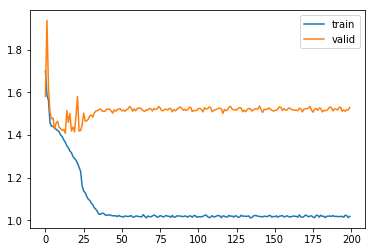

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "valid"])

# cnn model with multiple tasks

In [43]:
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

def map_example_to_simple_train(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

def get_batched_dataset(filenames, batch_size, m_ids, max_queue_size=10,  n_process=4, map_example=None):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
#     if is_train:
#         dataset = dataset.map(map_example_to_simple_train, num_parallel_calls=n_process)
#     else:
    dataset = dataset.map(map_example, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[0], -1))
    dataset = dataset.filter(lambda x, y: tf.math.reduce_std(x) > 0.05)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))

    
    dataset = dataset.repeat()
#     if is_train:
    dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
#     if is_train:
    dataset = dataset.prefetch(max_queue_size)
#     else:
#         dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [63]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [64]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error","mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1_64 (Batc (None, 1500, 3)      12          input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 1500, 16)     160         batch_normalization_v1_64[0][0]  
__________________________________________________________________________________________________
leaky_re_lu_72 (LeakyReLU)      (None, 1500, 16)     0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [65]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=256)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=256)

In [66]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm2.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 3.7351 - on_off_loss: 1.9878 - dyskinesia_loss: 0.8362 - tremor_loss: 0.9110
Epoch 00001: val_loss improved from inf to 3.95291, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 89s 178ms/step - loss: 3.7372 - on_off_loss: 1.9885 - dyskinesia_loss: 0.8370 - tremor_loss: 0.9117 - val_loss: 3.9529 - val_on_off_loss: 1.7510 - val_dyskinesia_loss: 1.0070 - val_tremor_loss: 1.1949
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 3.4773 - on_off_loss: 1.8517 - dyskinesia_loss: 0.7781 - tremor_loss: 0.8474
Epoch 00002: val_loss improved from 3.95291 to 3.60927, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 63s 126ms/step - loss: 3.4761 - on_off_loss: 1.8508 - dyskinesia_loss: 0.7780 - tremor_loss: 0.8473 - val_loss: 3.6093 - val_on_off_loss: 1.7745 - val_dyskinesia_loss: 0.9310 - val_tremor_loss: 0.9037
Epoch 3/200
499/

Epoch 19/200
499/500 [============================>.] - ETA: 0s - loss: 1.1608 - on_off_loss: 0.5737 - dyskinesia_loss: 0.2729 - tremor_loss: 0.3142
Epoch 00019: val_loss did not improve from 3.27607
500/500 [==============================] - 63s 126ms/step - loss: 1.1613 - on_off_loss: 0.5738 - dyskinesia_loss: 0.2732 - tremor_loss: 0.3143 - val_loss: 3.8339 - val_on_off_loss: 2.0338 - val_dyskinesia_loss: 0.9199 - val_tremor_loss: 0.8802
Epoch 20/200
499/500 [============================>.] - ETA: 0s - loss: 1.1214 - on_off_loss: 0.5477 - dyskinesia_loss: 0.2666 - tremor_loss: 0.3071
Epoch 00020: val_loss did not improve from 3.27607
500/500 [==============================] - 63s 125ms/step - loss: 1.1210 - on_off_loss: 0.5476 - dyskinesia_loss: 0.2665 - tremor_loss: 0.3069 - val_loss: 3.9257 - val_on_off_loss: 2.1199 - val_dyskinesia_loss: 0.9266 - val_tremor_loss: 0.8793
Epoch 21/200
499/500 [============================>.] - ETA: 0s - loss: 1.0771 - on_off_loss: 0.5234 - dyskinesi

In [67]:
history.history.keys()

dict_keys(['loss', 'on_off_loss', 'dyskinesia_loss', 'tremor_loss', 'val_loss', 'val_on_off_loss', 'val_dyskinesia_loss', 'val_tremor_loss', 'lr'])

In [69]:
import matplotlib.pyplot as plt
from addict import Dict

In [71]:
history = Dict(history.history)

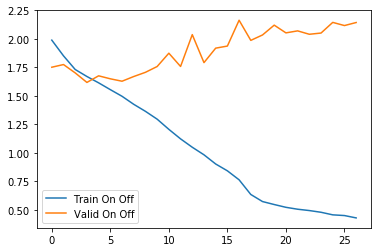

In [73]:
plt.plot(history.on_off_loss)
plt.plot(history.val_on_off_loss)
plt.legend(["Train On Off", "Valid On Off"])

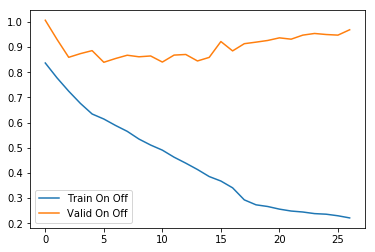

In [74]:
plt.plot(history.dyskinesia_loss)
plt.plot(history.val_dyskinesia_loss)
plt.legend(["Train Dyskinesia", "Valid Dyskinesia"])

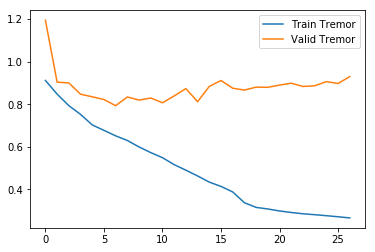

In [75]:
plt.plot(history.tremor_loss)
plt.plot(history.val_tremor_loss)
plt.legend(["Train Tremor", "Valid Tremor"])

# More parameters and regularization

In [8]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=512)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=512)

NameError: name 'get_batched_dataset' is not defined

In [9]:
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [143]:
num_cnn_layers = 5
num_lstm_layers = 0
num_lin_layers = 3
dropout = 0.5
lin_h=512
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.05)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [144]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 1500, 3)      0           input_85[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_314 (Bat (None, 1500, 3)      12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv1d_145 (Conv1D)             (None, 1500, 16)     160         batch_normalization_v1_314[0][0] 
__________________________________________________________________________________________________
leaky_re_l

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm2.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 4.8427 - on_off_loss: 2.3068 - dyskinesia_loss: 1.1412 - tremor_loss: 1.3947
Epoch 00001: val_loss improved from inf to 5.04465, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 116s 231ms/step - loss: 4.8431 - on_off_loss: 2.3071 - dyskinesia_loss: 1.1412 - tremor_loss: 1.3948 - val_loss: 5.0446 - val_on_off_loss: 2.3104 - val_dyskinesia_loss: 1.1992 - val_tremor_loss: 1.5350
Epoch 2/200
498/500 [============================>.] - ETA: 0s - loss: 4.8880 - on_off_loss: 2.3345 - dyskinesia_loss: 1.1494 - tremor_loss: 1.4042
Epoch 00002: val_loss improved from 5.04465 to 5.01986, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 43s 87ms/step - loss: 4.8882 - on_off_loss: 2.3348 - dyskinesia_loss: 1.1494 - tremor_loss: 1.4040 - val_loss: 5.0199 - val_on_off_loss: 2.3011 - val_dyskinesia_loss: 1.1922 - val_tremor_loss: 1.5265
Epoch 3/200
498/

# Data Augmentation with Rotations

It is generally believed that watches can be rotated somewhat. We don't remove the gravity component still, so the network should be able to figure out 

In [13]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))

In [14]:
tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)))

<tf.Tensor 'Reshape:0' shape=(3, 3) dtype=float32>

In [15]:
std = 1/16 #allow deviation from real rotation with pi/16 std
def map_example_to_simple_train(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    data = data @ update_matrix
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [16]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128, is_train=True)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=512, is_train=False)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=512, is_train=False)

In [17]:
c = 0
for record in tf.python_io.tf_record_iterator("/n/scratch2/beat_pd_ms_tmp/all_data.tfr"):
    c += 1
c

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


204098

In [14]:
num_cnn_layers = 5
num_lstm_layers = 0
num_lin_layers = 5
dropout = 0.5
lin_h=512
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.01)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.compile(tf.keras.optimizers.Adam(lr=0.001), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ])
model.summary()

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 1500, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1500, 16)     160         gaussian_noise[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1500, 16)     0           conv1d[0][0]                     
_____________________________________________________________

In [16]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm2.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 4.6631 - on_off_loss: 2.2437 - dyskinesia_loss: 1.2006 - tremor_loss: 1.2188
Epoch 00001: val_loss improved from inf to 3.43121, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 105s 209ms/step - loss: 4.6611 - on_off_loss: 2.2433 - dyskinesia_loss: 1.1997 - tremor_loss: 1.2181 - val_loss: 3.4312 - val_on_off_loss: 1.6491 - val_dyskinesia_loss: 0.8299 - val_tremor_loss: 0.9522
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 3.8887 - on_off_loss: 1.9107 - dyskinesia_loss: 1.0052 - tremor_loss: 0.9727
Epoch 00002: val_loss improved from 3.43121 to 3.35283, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 87s 175ms/step - loss: 3.8892 - on_off_loss: 1.9108 - dyskinesia_loss: 1.0056 - tremor_loss: 0.9729 - val_loss: 3.3528 - val_on_off_loss: 1.6161 - val_dyskinesia_loss: 

Epoch 18/200
499/500 [============================>.] - ETA: 0s - loss: 3.4657 - on_off_loss: 1.7608 - dyskinesia_loss: 0.8820 - tremor_loss: 0.8229
Epoch 00018: val_loss improved from 3.16441 to 3.15552, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 90s 180ms/step - loss: 3.4655 - on_off_loss: 1.7604 - dyskinesia_loss: 0.8822 - tremor_loss: 0.8229 - val_loss: 3.1555 - val_on_off_loss: 1.5921 - val_dyskinesia_loss: 0.7373 - val_tremor_loss: 0.8261
Epoch 19/200
499/500 [============================>.] - ETA: 0s - loss: 3.4541 - on_off_loss: 1.7576 - dyskinesia_loss: 0.8772 - tremor_loss: 0.8192
Epoch 00019: val_loss improved from 3.15552 to 3.15048, saving model to /n/scratch2/ms994/cnnlstm2.h5
500/500 [==============================] - 90s 180ms/step - loss: 3.4539 - on_off_loss: 1.7575 - dyskinesia_loss: 0.8772 - tremor_loss: 0.8192 - val_loss: 3.1505 - val_on_off_loss: 1.5892 - val_dyskinesia_loss: 0.7365 - val_tremor_loss: 0.8248
Epoch 20/2

Epoch 36/200
499/500 [============================>.] - ETA: 0s - loss: 3.3808 - on_off_loss: 1.7327 - dyskinesia_loss: 0.8490 - tremor_loss: 0.7991
Epoch 00036: val_loss did not improve from 3.12954
500/500 [==============================] - 90s 180ms/step - loss: 3.3799 - on_off_loss: 1.7324 - dyskinesia_loss: 0.8487 - tremor_loss: 0.7988 - val_loss: 3.1408 - val_on_off_loss: 1.5969 - val_dyskinesia_loss: 0.7307 - val_tremor_loss: 0.8132
Epoch 37/200
499/500 [============================>.] - ETA: 0s - loss: 3.3664 - on_off_loss: 1.7290 - dyskinesia_loss: 0.8436 - tremor_loss: 0.7937
Epoch 00037: val_loss did not improve from 3.12954
500/500 [==============================] - 90s 180ms/step - loss: 3.3655 - on_off_loss: 1.7288 - dyskinesia_loss: 0.8434 - tremor_loss: 0.7933 - val_loss: 3.1410 - val_on_off_loss: 1.5956 - val_dyskinesia_loss: 0.7331 - val_tremor_loss: 0.8123
Epoch 38/200
499/500 [============================>.] - ETA: 0s - loss: 3.3730 - on_off_loss: 1.7329 - dyskinesi

In [17]:
import pickle as pkl
pkl.dump(history.history, open("history3.pkl", "wb"))

In [18]:
import matplotlib.pyplot as plt
from addict import Dict
history = Dict(history.history)

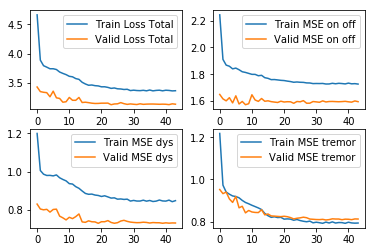

In [26]:
plt.subplot(2,2,1)
plt.plot(history.loss)
plt.plot(history.val_loss)
plt.legend(["Train Loss Total", "Valid Loss Total"])
plt.subplot(2,2,2)
plt.plot(history.on_off_loss)
plt.plot(history.val_on_off_loss)
plt.legend(["Train MSE on off", "Valid MSE on off"])
plt.subplot(2,2,3)
plt.plot(history.dyskinesia_loss)
plt.plot(history.val_dyskinesia_loss)
plt.legend(["Train MSE dys", "Valid MSE dys"])
plt.subplot(2,2,4)
plt.plot(history.tremor_loss)
plt.plot(history.val_tremor_loss)
plt.legend(["Train MSE tremor", "Valid MSE tremor"])




# Try increasing complexity

In [45]:
def map_example_test(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0], example["measurement_id"], example["subjects"])

In [50]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128, map_example=map_example_to_simple_train)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=512, map_example=map_example_to_simple)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=512, map_example=map_example_test)

In [21]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 5
dropout = 0.5
lin_h=512
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.01)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(64, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [22]:
model.compile(tf.keras.optimizers.Adam(lr=0.001), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 1500, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1500, 64)     640         gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 1500, 64)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [24]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.9)

history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping, lr_schedule])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 4.2475 - on_off_loss: 2.1368 - dyskinesia_loss: 1.0260 - tremor_loss: 1.0847
Epoch 00001: val_loss improved from inf to 3.36772, saving model to /n/scratch2/ms994/cnnlstm3.h5
500/500 [==============================] - 103s 205ms/step - loss: 4.2457 - on_off_loss: 2.1358 - dyskinesia_loss: 1.0256 - tremor_loss: 1.0843 - val_loss: 3.3677 - val_on_off_loss: 1.7619 - val_dyskinesia_loss: 0.8722 - val_tremor_loss: 0.7336
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 3.5450 - on_off_loss: 1.7975 - dyskinesia_loss: 0.8575 - tremor_loss: 0.8900
Epoch 00002: val_loss improved from 3.36772 to 3.26576, saving model to /n/scratch2/ms994/cnnlstm3.h5
500/500 [==============================] - 80s 159ms/step - loss: 3.5439 - on_off_loss: 1.7973 - dyskinesia_loss: 0.8571 - tremor_loss: 0.8896 - val_loss: 3.2658 - val_on_off_loss: 1.7183 - val_dyskinesia_loss: 0.8398 - val_tremor_loss: 0.7076
Epoch 3/200
499

Epoch 19/200
499/500 [============================>.] - ETA: 0s - loss: 2.3150 - on_off_loss: 1.2353 - dyskinesia_loss: 0.5310 - tremor_loss: 0.5487
Epoch 00019: val_loss improved from 2.89752 to 2.89739, saving model to /n/scratch2/ms994/cnnlstm3.h5
500/500 [==============================] - 82s 164ms/step - loss: 2.3146 - on_off_loss: 1.2353 - dyskinesia_loss: 0.5308 - tremor_loss: 0.5486 - val_loss: 2.8974 - val_on_off_loss: 1.5993 - val_dyskinesia_loss: 0.6940 - val_tremor_loss: 0.6041
Epoch 20/200
499/500 [============================>.] - ETA: 0s - loss: 2.2946 - on_off_loss: 1.2239 - dyskinesia_loss: 0.5237 - tremor_loss: 0.5470
Epoch 00020: val_loss did not improve from 2.89739
500/500 [==============================] - 81s 162ms/step - loss: 2.2950 - on_off_loss: 1.2238 - dyskinesia_loss: 0.5238 - tremor_loss: 0.5473 - val_loss: 2.9112 - val_on_off_loss: 1.6007 - val_dyskinesia_loss: 0.7092 - val_tremor_loss: 0.6012
Epoch 21/200
499/500 [============================>.] - ETA: 

Epoch 37/200
499/500 [============================>.] - ETA: 0s - loss: 2.2412 - on_off_loss: 1.1961 - dyskinesia_loss: 0.5132 - tremor_loss: 0.5319
Epoch 00037: val_loss did not improve from 2.89613
500/500 [==============================] - 81s 163ms/step - loss: 2.2416 - on_off_loss: 1.1963 - dyskinesia_loss: 0.5135 - tremor_loss: 0.5319 - val_loss: 2.9147 - val_on_off_loss: 1.5981 - val_dyskinesia_loss: 0.7151 - val_tremor_loss: 0.6015
Epoch 38/200
499/500 [============================>.] - ETA: 0s - loss: 2.2413 - on_off_loss: 1.1969 - dyskinesia_loss: 0.5137 - tremor_loss: 0.5307
Epoch 00038: val_loss did not improve from 2.89613
500/500 [==============================] - 82s 163ms/step - loss: 2.2410 - on_off_loss: 1.1967 - dyskinesia_loss: 0.5138 - tremor_loss: 0.5305 - val_loss: 2.9170 - val_on_off_loss: 1.5998 - val_dyskinesia_loss: 0.7158 - val_tremor_loss: 0.6013
Epoch 39/200
499/500 [============================>.] - ETA: 0s - loss: 2.2511 - on_off_loss: 1.2041 - dyskinesi

In [25]:
import pickle as pkl
pkl.dump(history.history, open("history4.pkl", "wb"))

In [26]:
import matplotlib.pyplot as plt
from addict import Dict
history = Dict(history.history)

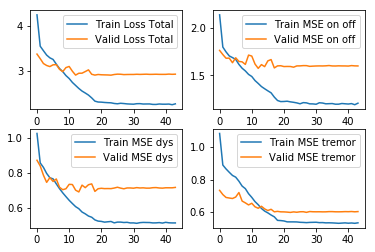

In [27]:
plt.subplot(2,2,1)
plt.plot(history.loss)
plt.plot(history.val_loss)
plt.legend(["Train Loss Total", "Valid Loss Total"])
plt.subplot(2,2,2)
plt.plot(history.on_off_loss)
plt.plot(history.val_on_off_loss)
plt.legend(["Train MSE on off", "Valid MSE on off"])
plt.subplot(2,2,3)
plt.plot(history.dyskinesia_loss)
plt.plot(history.val_dyskinesia_loss)
plt.legend(["Train MSE dys", "Valid MSE dys"])
plt.subplot(2,2,4)
plt.plot(history.tremor_loss)
plt.plot(history.val_tremor_loss)
plt.legend(["Train MSE tremor", "Valid MSE tremor"])




In [87]:
%%bash
scancel 3230706

In [51]:
test_iter = test_data.make_one_shot_iterator()

In [62]:
y_onoff_all = []
y_dys_all = []
y_trem_all = []
y_meas_all = []
y_subject_all = []
y_pred_all = []
with tf.Session() as sess:
    model = tf.keras.models.load_model("/n/scratch2/ms994/cnnlstm3.h5")   
    xy = test_iter.get_next()
    for i in range(200):
        print(i)
        x = xy[0]
        y_pred_all.append(model.predict(x, steps=1))
        y = xy[1]
        y_onoff_all.append(y[0].eval())
        y_dys_all.append(y[1].eval())   
        y_trem_all.append(y[2].eval())
        y_meas_all.append(y[3].eval())   
        y_subject_all.append(y[4].eval())                

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7fa534820510>
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [66]:
import numpy as np

In [71]:
y_pred_all = np.hstack(y_pred_all).reshape((3,-1)).T

In [72]:
import seaborn as sns

In [88]:
data = pd.DataFrame([np.hstack(y_onoff_all), y_pred_all[:, 0]])

In [91]:
data = data.T
data.columns = ["True", "Pred"]

In [87]:
y_pred_all.shape

(102400, 3)

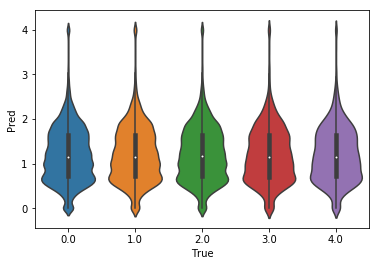

In [92]:
sns.violinplot(x="True", y="Pred", data=data)

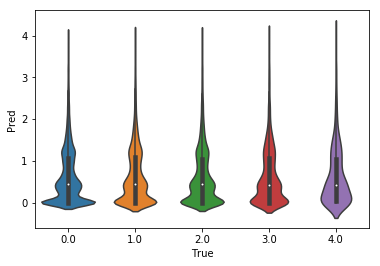

In [93]:
data = pd.DataFrame([np.hstack(y_dys_all), y_pred_all[:, 1]])
data = data.T
data.columns = ["True", "Pred"]
sns.violinplot(x="True", y="Pred", data=data)

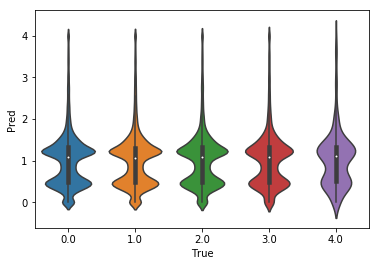

In [95]:
data = pd.DataFrame([np.hstack(y_trem_all), y_pred_all[:, 2]])
data = data.T
data.columns = ["True", "Pred"]
sns.violinplot(x="True", y="Pred", data=data)

In [102]:
y_pred_all_df = pd.DataFrame([*y_pred_all.T, np.hstack(y_onoff_all), np.hstack(y_dys_all), np.hstack(y_trem_all), np.vstack(y_meas_all).reshape(-1), np.vstack(y_subject_all).reshape(-1)])

In [103]:
y_pred_all_df.T.head()

,0,1,2,3,4,5,6,7
0,0.425023,0.000000,0.134945,1.0,0.0,3.0,285.0,12.0
1,1.832503,0.498731,1.537395,0.0,0.0,2.0,748.0,8.0
2,1.573477,2.203925,2.582823,4.0,0.0,1.0,724.0,12.0
3,0.758617,1.457134,0.850033,3.0,0.0,1.0,576.0,3.0
4,0.819895,0.321378,1.207016,0.0,0.0,4.0,795.0,1.0


In [105]:
y_pred_all_df = y_pred_all_df.T
y_pred_all_df.columns = ["onoff_pred", "dysk_pred", "trem_pred", "onoff_true", "dysk_true", "trem_true", "m_id", "s_id"]

In [106]:
y_pred_all_df.head()

,onoff_pred,dysk_pred,trem_pred,onoff_true,dysk_true,trem_true,m_id,s_id
0,0.425023,0.000000,0.134945,1.0,0.0,3.0,285.0,12.0
1,1.832503,0.498731,1.537395,0.0,0.0,2.0,748.0,8.0
2,1.573477,2.203925,2.582823,4.0,0.0,1.0,724.0,12.0
3,0.758617,1.457134,0.850033,3.0,0.0,1.0,576.0,3.0
4,0.819895,0.321378,1.207016,0.0,0.0,4.0,795.0,1.0


In [116]:
ensemble_dysk = y_pred_all_df.groupby("s_id")["dysk_pred", "dysk_true"].mean()

In [115]:
y_pred_all_df[y_pred_all_df.s_id==0]

,onoff_pred,dysk_pred,trem_pred,onoff_true,dysk_true,trem_true,m_id,s_id


In [117]:
ensemble_dysk

,dysk_pred,dysk_true
s_id,,
1.0,0.657973,0.637625
3.0,0.645259,0.650173
6.0,0.646425,0.651770
8.0,0.652206,0.661845
11.0,0.642416,0.619065
12.0,0.646716,0.653252
15.0,0.646175,0.659009
18.0,0.641403,0.684673
19.0,0.637236,0.638533


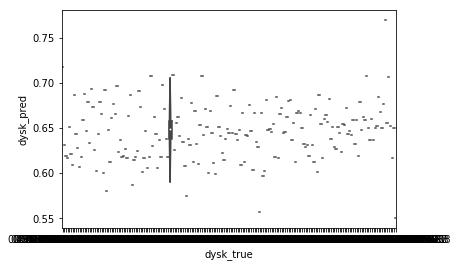

In [111]:
sns.violinplot(x="dysk_true", y="dysk_pred", data=ensemble_dysk)

In [31]:
model.metrics += model.outputs

AttributeError: can't set attribute

In [51]:
model.evaluate(test_data, steps=200)

 84/200 [===========>..................] - ETA: 1:03 - loss: 6.8676 - on_off_loss: 3.3251 - dyskinesia_loss: 1.5043 - tremor_loss: 2.0383

KeyboardInterrupt: 

# Homeoschedastic Layer

In [103]:
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return (data, example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],), (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

def get_batched_dataset(filenames, batch_size, m_ids, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_example_to_simple, num_parallel_calls=n_process)
#     dataset = dataset.filter(lambda x, y: tf.not_equal(y[0], -1))
    dataset = dataset.filter(lambda x, y: tf.math.reduce_std(x[0]) > 0.05)
#     dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
#     dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [118]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Custom loss layer
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(tf.boolean_mask(precision * (y_true - y_pred)**2. + log_var[0], tf.equal(y_true, -1)), -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

In [130]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)
x_on_off_input = tf.keras.layers.Input((1,))

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)
x_dyskinesia_input = tf.keras.layers.Input((1,))

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)
x_tremor_input = tf.keras.layers.Input((1,))

x_homeo = CustomMultiLossLayer(nb_outputs=3)([x_on_off, x_dyskinesia, x_tremor, x_on_off_input, x_dyskinesia_input, x_tremor_input])
x_homeo_on_off_out = tf.keras.layers.Lambda(lambda x:  x[3])(x_homeo)
x_homeo_dys_out = tf.keras.layers.Lambda(lambda x:  x[4])(x_homeo)
x_homeo_tremor_out = tf.keras.layers.Lambda(lambda x:  x[5])(x_homeo)

model = tf.keras.Model([inputLayer, x_on_off_input, x_dyskinesia_input, x_tremor_input], [x_homeo_on_off_out, x_homeo_dys_out, x_homeo_tremor_out])
model.compile("adam", loss=["mean_squared_error", "mean_squared_error", "mean_squared_error"], loss_weights=[0,0,0])

In [131]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=256)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=256)

In [133]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm2.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit_generator(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200


TypeError: 'Iterator' object is not an iterator